# Finite Mixture Model

In [1]:
import seaborn as sns
%matplotlib notebook

<IPython.core.display.Javascript object>


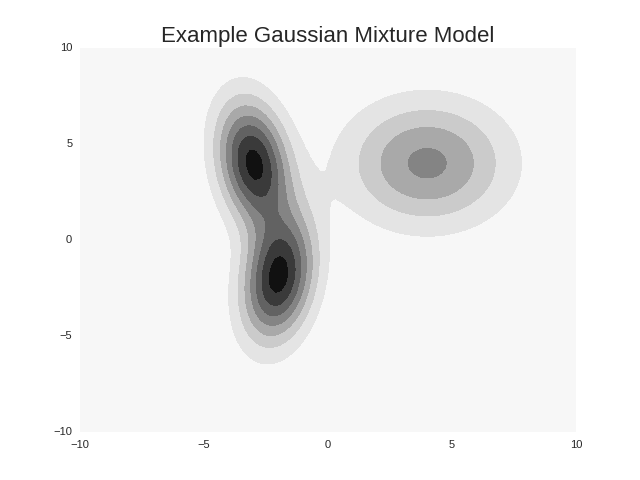

/usr/local/lib/python2.7/dist-packages/pypr/clustering/gmm.py:132: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
  if pdf==None:


In [2]:
# Example GMM
from pypr.clustering import gmm
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D

# Our 2-dimensional distribution will be over variables X and Y
N = 100
X = np.linspace(-10, 10, N)
Y = np.linspace(-10, 10, N)
X, Y = np.meshgrid(X, Y)

# Pack X and Y into a single 3-dimensional array
pos = np.empty(X.shape + (2,))
pos[:, :, 0] = X
pos[:, :, 1] = Y
pos = np.concatenate(pos, axis=0)

# Mean vector and covariance matrix
mix = np.array([0.3, 0.3, 0.4])
mu1 = np.array([-2, -2.])
mu2 = np.array([-3, 4.])
mu3 = np.array([4, 4])
Sigma = np.array([[ 1. , 0.5], [0.5,  5.]])
Sigma2 = np.array([[ 1. , -.5], [-.5,  5.]])
Sigma3 = np.array([[ 5. , 0], [0,  5.]])

# The distribution on the variables X, Y packed into pos.
fig = plt.figure()
ax = fig.gca()
plt.contourf(X, Y, gmm.gmm_pdf(pos, [mu1, mu2, mu3], [Sigma, Sigma2, Sigma3], mix).reshape(N, N))
plt.title('Example Gaussian Mixture Model', fontsize=20)
fig.canvas.draw()

<IPython.core.display.Javascript object>


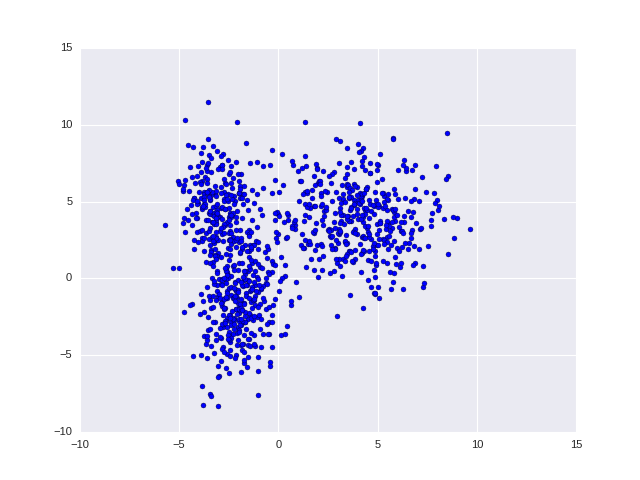

In [3]:
# Sample points from the real GMM and estimate a GMM for those points. Hopefully they will be the same!
N = 1000
d = 2
X = gmm.sample_gaussian_mixture([mu1, mu2, mu3], [Sigma, Sigma2, Sigma3], mc=mix, samples=N)
fig = plt.figure()
plt.scatter(X[:, 0], X[:, 1])
plt.show()

In [4]:
X.shape

(1000, 2)

## The Mixture Model
Let's find a model that describes the generation process of these data. This model will be a **Bayesian Finite Gaussian Mixture Model**. This means it is a sum of $K$ weighted normal distributions (components) parametrized by their means and covariance matrices. Each point in the data set will belong to one of the gaussians.

The parameters we need to estimate are then: the cluster assignment of each data point, the mixture weights and the mean and covariance matrix of each component.

We assign priors to each of these parameters:
* Mixture weights $\mathbf{\pi} = [\pi_1, ..., \pi_K]$ are Dirichlet-distributed, with parameter vector $\mathbf{\alpha} = [\alpha/K, ..., \alpha/K]$;
* Cluster assignments $z_n$ assume values from $1$ to $K$ and are sampled from a discrete distribution with probabilities given by the mixture weights $\mathbf{\pi} = [\pi_1, ..., \pi_K]$;
* The joint prior distribution of the mean and covariance matrix of each component is a Normal-Inverse-Wishart distribution with hyperparameters $\{\mu_0, \lambda\}$ for the Normal, which is prior to the mean, and $\{\Psi, \upsilon\}$ for the inverse-Wishart, which is prior to the covariance matrix.

In [5]:
# Define prior distributions
from scipy.stats import dirichlet, invwishart, multivariate_normal, invgamma, wishart

# Hyperpriors
def sample_alpha(nsamples=1):
    return invgamma.rvs(a=1, scale=1, size=nsamples)

def sample_lam(nsamples=1):
    return invgamma.rvs(a=1, scale=1, size=nsamples)

def sample_mu0(nsamples=1):
    return multivariate_normal.rvs(mean=np.mean(X, axis=0), cov=np.cov(X.T), size=nsamples)

def sample_psi(nsamples=1):
    return wishart.rvs(scale=np.cov(X.T) / d, df=d, size=nsamples)

def sample_ups(nsamples=1):
    return invgamma.rvs(1, 1/d) + d

# Priors
def sample_dirichlet(alphas, nsamples=1):
    return dirichlet.rvs(alpha=alphas, size=nsamples).T

def sample_normal_inv_wishart(mu0, lam, psi, ups, nsamples=1):
    covariance = invwishart.rvs(scale=psi, df=ups, size=nsamples)
    mean = np.ones((nsamples, d))
    for k in range(nsamples):
        mean[k] = multivariate_normal.rvs(mean=mu0.ravel(), cov=covariance[k] * 1/lam, size=1)
    return (mean, covariance)   

def sample_normal_wishart(mu0, lam, psi, ups, nsamples=1):
    covariance = np.linalg.inv(wishart.rvs(scale=psi, df=ups, size=nsamples))
    mean = np.ones((nsamples, d))
    for k in range(nsamples):
        mean[k] = multivariate_normal.rvs(mean=mu0.ravel(), cov=covariance[k] * 1/lam, size=1)
    return (mean, covariance)  

# Estimate parameter from samples
def gibbs_estimate(samples, n_burnin=30):
    n_samples = len(samples)
    estimate = np.sum(samples[n_burnin:], axis=0)
    estimate = estimate / (n_samples - n_burnin)
    return estimate

In [6]:
# Update NIW parameters
def update_niw_parameters(data, mu0, lam, psi, ups):
    data_mean = np.mean(data, axis=0)
    n = data.shape[0]
    
    mun = (lam * mu0 + n*data_mean) / (lam + n)
    lamn = lam + n
    upsn = ups + n
    psin = psi + np.matmul((data - data_mean).T, data - data_mean) + (lam*n / (lam + n)) * np.matmul((data_mean - mu0).T, data_mean - mu0)
    return mun, lamn, psin, upsn

# Update NW parameters
def update_nw_parameters(data, mu0, k0, W0, v0):
    data_mean = np.mean(data, axis=0)
    n = data.shape[0]
    
    mun = (k0 * mu0 + n*data_mean) / (k0 + n)
    kn = k0 + n
    vn = v0 + n
    Wn = np.linalg.inv(np.linalg.inv(W0) + np.matmul((data - data_mean).T, data - data_mean) + (k0*n / (k0 + n)) * np.matmul((data_mean - mu0).T, data_mean - mu0))
    return mun, kn, Wn, vn

In [7]:
def cluster_probs_at_point(x, means, covs, pis):
    probs = [(pis[k] * multivariate_normal.pdf(x, mean=means[k], cov=covs[k])) for k in range(K)]
    probs = probs / np.sum(probs)
    return probs

In [8]:
# Log likelihood
def log_likelihood(data, means, covs, pis):
    """Data log-likeliehood
    
    Equation 2.153 in Sudderth
    """
    ll = 0
    for i in range(data.shape[0]):
        probs = 0
        for k in range(K):
            probs = probs +  pis[k] * multivariate_normal.pdf(data[i], mean=means[k], cov=covs[k])
        ll = ll + np.log10(probs)
        
    return ll

In [9]:
# Resulting GMM
def plot_est_gmm(mu_est, cov_est, pi_est, fig_handler, title=None):
    N = 100
    x = np.linspace(-10, 10, N)
    y = np.linspace(-10, 10, N)
    x, y = np.meshgrid(x, y)

    # Pack X and Y into a single 3-dimensional array
    pos = np.empty(x.shape + (2,))
    pos[:, :, 0] = x
    pos[:, :, 1] = y
    pos = np.concatenate(pos, axis=0)

    z = gmm.gmm_pdf(pos, mu_est, cov_est, pi_est).reshape(N, N)

    # The distribution on the variables X, Y packed into pos.
    ax = fig_handler.gca()
    plt.contourf(x, y, z)
    if title == None:
        title = 'Estimated GMM'
    plt.title(title, fontsize=20)   
    fig_handler.canvas.draw()

In [10]:
K = 3 # number of clusters

# Hyperparameters
# Dirichlet
alpha = 100
alpha_arr = alpha * np.ones((K,))

# NIW
# need [mu0, lam, psi, ups] for each cluster k
mu0 = np.mean(X, axis=0).reshape(1, d)
lam = .2
psi = np.eye(d) * 1.5
ups = d

In [18]:
# Assignment vector: N x 1
z = np.zeros((N,))
z_runlist = []

# Number of data points per cluster:
nk = np.zeros((K,))

# Mixture weights vector: K x 1
pi = np.zeros((K,))
pi_runlist = []

# Mean vector: K x d
mu = np.zeros((K, d))
mu_runlist = []

# Covariance matrix: K x d x d
cov = np.zeros((K, d, d))
cov_runlist = []

<IPython.core.display.Javascript object>


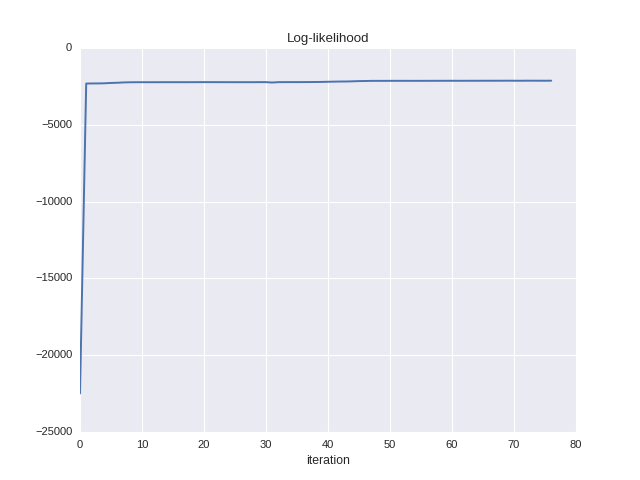

<IPython.core.display.Javascript object>


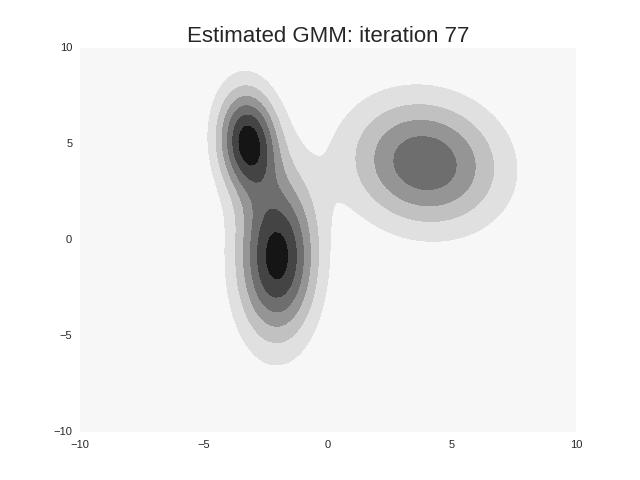

KeyboardInterrupt: 

In [70]:
save_plot = False
path = 'figures/'

fig1 = plt.figure(4)
ax = fig1.add_subplot(111)
plt.ion() 
fig1.show()
fig1.canvas.draw()

fig2 = plt.figure(5)
ax = fig2.add_subplot(111)
plt.ion() 
fig2.show()
fig2.canvas.draw()

# Gibbs sampling
niterations = 100

lls = np.ones((niterations, 1))

# Initialize parameters with samples from the prior distributions
alpha_arr = sample_alpha() * np.ones((K,))
pi = sample_dirichlet(alpha_arr)
mu0, lam, psi, ups = sample_mu0(), sample_lam(), sample_psi(), sample_ups()
# mu0 = np.mean(X, axis=0).reshape(1, d)
# lam = .2
# psi = np.eye(d) * 1.5
# ups = d
mu, cov = sample_normal_wishart(mu0, lam, psi, ups, K)

for i in range(0, niterations):
    lls[i] = log_likelihood(X, mu, cov, pi)
    
    plt.figure(4)
    plt.gcf().clear()
    plt.plot(lls[:i])
    plt.xlabel("iteration")
    plt.legend()
    plt.title('Log-likelihood')
    fig1.canvas.draw()
    
    plt.figure(5)
    plt.gcf().clear()
    plot_est_gmm(mu, cov, pi, fig2, title='Estimated GMM: iteration ' + str(i))
    if save_plot:
        plt.savefig(path + str(i) + '.jpg')
    
    for n in range(N):
        probs = np.array(cluster_probs_at_point(X[n], mu, cov, pi)).ravel()
        z[n] = np.random.choice(range(K), p=probs)
        
    for k in range(K):
        nk[k] = 0
        for n in range(N):
            if z[n] == k:
                nk[k] += 1
                
    alpha_arr = sample_alpha() * np.ones((K,))
    pi = sample_dirichlet(alpha_arr + nk)
    for k in range(K):
        #mu0, lam, psi, ups = sample_mu0(), sample_lam(), sample_psi(), sample_ups()
        mun, lamn, psin, upsn = update_nw_parameters(X[np.argwhere(z==k).ravel()], mu0, lam, psi, ups)
        mu[k], cov[k] = sample_normal_wishart(mun, lamn, psin, upsn)

    z_runlist.append(z)
    pi_runlist.append(pi)
    mu_runlist.append(mu)
    cov_runlist.append(cov)

In [13]:
# Estimate the true parameters from the samples
z_est = gibbs_estimate(z_runlist)
pi_est = gibbs_estimate(pi_runlist)
mu_est = gibbs_estimate(mu_runlist)
cov_est = gibbs_estimate(cov_runlist)

In [14]:
mu

array([[ 4.07536222,  3.98965283],
       [-2.12460919, -0.2050288 ],
       [-3.423408  ,  5.11025297]])

<IPython.core.display.Javascript object>


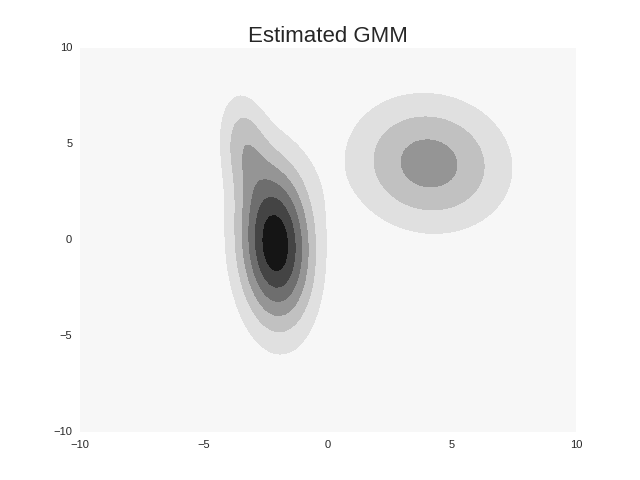

In [15]:
fig = plt.figure()
plot_est_gmm(mu_est, cov_est, pi_est, fig)